In [1]:
import numpy as np
import plotly.graph_objects as go

# ---------------------------
# helpers
# ---------------------------
rng = np.random.default_rng(1)  # set.seed(1)

def rdir(n, k):
    """Dirichlet via i.i.d. Exp then row-normalize."""
    m = rng.exponential(scale=1.0, size=(n, k))
    return m / m.sum(axis=1, keepdims=True)

def segments_from_origin(P):
    """Return x,y,z lists to draw short segments 0 -> P[i] with breaks."""
    xs, ys, zs = [], [], []
    for x, y, z in P:
        xs += [0.0, float(x), None]
        ys += [0.0, float(y), None]
        zs += [0.0, float(z), None]
    return dict(x=xs, y=ys, z=zs)

def bary_to_2d(ABC):
    """Map barycentric weights to 2D triangle coords."""
    p1 = np.array([0.0, 0.0])
    p2 = np.array([1.0, 0.0])
    p3 = np.array([0.5, np.sqrt(3)/2])
    return (ABC[:, [0]] * p1 + ABC[:, [1]] * p2 + ABC[:, [2]] * p3)

In [2]:
# ---------------------------
# data construction
# ---------------------------
v1 = np.array([0.9, 0.2, 2.8])
v2 = np.array([0.3, 2.6, 1.2])
v3 = np.array([1.9, 2.8, 0.8])
V  = np.vstack([v1, v2, v3])         # (3, 3)

n_full = 300
W_all  = rdir(n_full, 3)             # weights
base   = W_all @ V                   # (n, 3)
t_mid  = 1.0 / base.sum(axis=1)      # scale to hit x+y+z=1
r_fac  = rng.uniform(0.5, 1.5, size=n_full)
Pts3D  = base * (t_mid * r_fac)[:, None]     # (n, 3)

# 2D projection 
Pts_star = Pts3D / Pts3D.sum(axis=1, keepdims=True)
Pts2     = bary_to_2d(Pts_star)

# short red rays (just beyond the plane), with labels h₁,h₂,h₃
alpha = 1.6
Rays  = np.vstack([
    alpha * v1 / v1.sum(),
    alpha * v2 / v2.sum(),
    alpha * v3 / v3.sum()
])

# h^* (2D projection)
ABC = np.vstack([v1 / v1.sum(), v2 / v2.sum(), v3 / v3.sum()])
V2_2d = bary_to_2d(ABC)

# canonical simplex vertices
p1 = np.array([0.0, 0.0])
p2 = np.array([1.0, 0.0])
p3 = np.array([0.5, np.sqrt(3)/2])

# plane color
plane_color = "#56B4E9"

In [3]:
# ---------------------------
# figure
# ---------------------------
fig = go.Figure()

# grey segments from origin to each point
seg_cloud = segments_from_origin(Pts3D)
fig.add_trace(go.Scatter3d(
    x=seg_cloud["x"], y=seg_cloud["y"], z=seg_cloud["z"],
    mode="lines",
    line=dict(width=1, color="gray"),
    opacity=0.85,
    hoverinfo="skip",
    showlegend=False
))

# cones at each point, pointing outward (like your R code)
fig.add_trace(go.Cone(
    x=Pts3D[:,0], y=Pts3D[:,1], z=Pts3D[:,2],
    u=Pts3D[:,0], v=Pts3D[:,1], w=Pts3D[:,2],
    anchor="tail",
    sizemode="absolute", sizeref=0.8,
    showscale=False,
    opacity=0.85,
    colorscale=[[0, "gray"], [1, "gray"]],
    hoverinfo="skip",
    name=""
))

# canonical simplex plane x+y+z = 1 (cyan, low opacity)
e1 = np.array([1.0, 0.0, 0.0])
e2 = np.array([0.0, 1.0, 0.0])
e3 = np.array([0.0, 0.0, 1.0])
fig.add_trace(go.Mesh3d(
    x=[e1[0], e2[0], e3[0]],
    y=[e1[1], e2[1], e3[1]],
    z=[e1[2], e2[2], e3[2]],
    i=[0], j=[1], k=[2],
    color=plane_color,  # explicit cyan
    opacity=0.22,
    lighting=dict(ambient=1, diffuse=0, specular=0, roughness=1, fresnel=0),
    flatshading=True,
    showscale=False,
    hoverinfo="skip",
    name=""
))

# red ray lines
seg_ray = segments_from_origin(Rays)
fig.add_trace(go.Scatter3d(
    x=seg_ray["x"], y=seg_ray["y"], z=seg_ray["z"],
    mode="lines",
    line=dict(width=3, color="red"),
    hoverinfo="skip",
    showlegend=False
))

# labels at ray tips (use Unicode subscripts)
labels = ["h\u2081", "h\u2082", "h\u2083"]
fig.add_trace(go.Scatter3d(
    x=Rays[:,0], y=Rays[:,1], z=Rays[:,2],
    mode="text",
    text=labels,
    textposition="top center",
    textfont=dict(color="red", size=14),
    hoverinfo="skip",
    showlegend=False
))

# small red cones at the ray tips (pointing outward)
fig.add_trace(go.Cone(
    x=Rays[:,0], y=Rays[:,1], z=Rays[:,2],
    u=Rays[:,0], v=Rays[:,1], w=Rays[:,2],
    anchor="tail",
    sizemode="absolute", sizeref=0.1,
    showscale=False,
    colorscale=[[0, "red"], [1, "red"]],
    hoverinfo="skip",
    name=""
))

# axes / camera
rng_max = max(1.2 * Pts3D.max(), 1.2 * Rays.max())
fig.update_layout(
    # width=500, height=500, 
    margin=dict(l=0, r=0, t=0, b=0),
    scene=dict(
        domain=dict(x=[0,1], y=[0,1]),
        aspectmode="cube",
        camera=dict(eye=dict(x=1.9, y=-1.8, z=0.2)), 
        bgcolor='rgba(0,0,0,0)',        # scene bg transparent
        xaxis=dict(
            showbackground=True,
            backgroundcolor='rgba(0,0,0,0)',  # transparent pane
            showgrid=True, gridcolor='lightgray', gridwidth=1,
            zeroline=False, 
            title="Pollutant 1", 
            range=[0, rng_max],
        ),
        yaxis=dict(
            showbackground=True,
            backgroundcolor='rgba(0,0,0,0)',
            showgrid=True, gridcolor='lightgray', gridwidth=1,
            zeroline=False, 
            title="Pollutant 2", 
            range=[0, rng_max],
        ),
        zaxis=dict(
            showbackground=True,
            backgroundcolor='rgba(0,0,0,0)',
            showgrid=True, gridcolor='lightgray', gridwidth=1,
            zeroline=False, 
            title="Pollutant 3", 
            range=[0, rng_max],
        )
    ) 
)

# fig.show()  # uncomment to view interactively

# ---------------------------
# saving (requires kaleido)
# ---------------------------
# pip install -U kaleido
# fig.write_image("data_cloud.pdf", width=500, height=500)

# Fallback without kaleido:
# fig.write_html("data_cloud.html", include_plotlyjs="cdn", full_html=True)

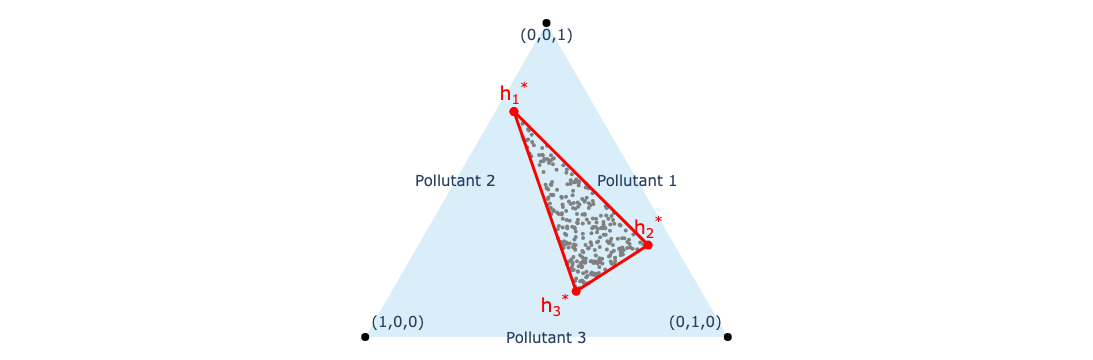

In [4]:
fig2d = go.Figure()

# fill the entire canonical simplex
fig2d.add_trace(go.Scatter(
    x=[p1[0], p2[0], p3[0], p1[0]],
    y=[p1[1], p2[1], p3[1], p1[1]],
    mode="lines",
    fill="toself", fillcolor=plane_color,
    opacity=0.22,
    line=dict(width=0, color=plane_color),
    hoverinfo="skip", showlegend=False,
))

# # light grey outline
# fig2d.add_trace(go.Scatter(
#     x=[p1[0], p2[0], p3[0], p1[0]],
#     y=[p1[1], p2[1], p3[1], p1[1]],
#     mode="lines",
#     line=dict(width=2, color="lightgrey"),
#     hoverinfo="skip", showlegend=False,
# ))

# grey points inside the simplex (expects Pts2 to exist: shape (n,2))
fig2d.add_trace(go.Scatter(
    x=Pts2[:,0], y=Pts2[:,1],
    mode="markers",
    marker=dict(size=4, color="gray"),
    hoverinfo="skip", showlegend=False,
))

# label the canonical simplex vertices
fig2d.add_trace(go.Scatter(
    x=[p1[0], p2[0], p3[0]],
    y=[p1[1], p2[1], p3[1]],
    mode="markers+text",
    marker=dict(size=8, color="black"),
    text=["(1,0,0)", "(0,1,0)", "(0,0,1)"],
    textfont=dict(size=15),
    textposition=["top right", "top left", "bottom center"],
    hoverinfo="skip", showlegend=False,
))

# triangle connecting h1*, h2*, h3* with labels (h2* placed below)
labels = [
    "h<sub>1</sub><sup>*</sup>",
    "h<sub>2</sub><sup>*</sup>",
    "h<sub>3</sub><sup>*</sup>",
]
fig2d.add_trace(go.Scatter(
    x=list(V2_2d[:,0]) + [V2_2d[0,0]],
    y=list(V2_2d[:,1]) + [V2_2d[0,1]],
    mode="lines+markers+text",
    line=dict(width=3, color="red"),
    marker=dict(size=9, color="red"),
    text=labels + [""],                 # close the loop with an empty label
    textposition=["top center","top center","bottom left","top center"],
    textfont=dict(size=19, color="red"),
    hoverinfo="skip", showlegend=False,
    texttemplate="%{text}" 
))

fig2d.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',   # page background
    plot_bgcolor='rgba(0,0,0,0)',    # plotting panel
    xaxis=dict(zeroline=False, showgrid=False, showticklabels=False),
    yaxis=dict(zeroline=False, showgrid=False, showticklabels=False),
    margin=dict(l=0, r=0, t=0, b=0, pad=0),
    scene=dict(domain=dict(x=[0,1], y=[0,1])),
    annotations=[
        dict(x=(p2[0]+p3[0])/2, y=(p2[1]+p3[1])/2, text="Pollutant 1", showarrow=False, font=dict(size=15)),
        dict(x=(p1[0]+p3[0])/2, y=(p1[1]+p3[1])/2, text="Pollutant 2", showarrow=False, font=dict(size=15)),
        dict(x=(p1[0]+p2[0])/2, y=(p1[1]+p2[1])/2, text="Pollutant 3", showarrow=False, font=dict(size=15)),
    ]
)
fig2d.update_yaxes(scaleanchor="x", scaleratio=1)

# fig2d.write_image("projection.pdf", width=500, height=500)